<h1 align=center>PRÁCTICA DEL MÓDULO DE NLP</h1>

<h3 align=center>ALUMNO: David Jiménez Vicente</h3>

 <h2 align=center>Notebook 3 : Modelado y Métricas</h2>

En este notebook vamos a realizar dos modelos.  
No separaré las métricas de los modelos en dos diferentes notebooks, ya que tiene mucho más sentido mostrar el modelo y sus métricas inmediatamente.  
· El primero será un modelo de ML que estará basado en extracción de features de palabras únicas con vectorizador TD-IDF para crear el Bag-Of-Words.  
· El segundo será un modelo neuronal basado en extracción de features usando embeddings con contexto.

<h2 align=center><i>Modelo 1: Modelo de Machine Learning</i></h2>

Importamos las librerías:

In [7]:
# Para los datos
import json
import pandas as pd
import numpy as np
import random

# Para dibujo
import matplotlib.pyplot as plt
import seaborn as sns

# Para el BOW
from sklearn import model_selection, naive_bayes, manifold, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# Para el modelo
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes


# Evaluación
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

# Para los embeddings
import gensim
import gensim.downloader as gensim_api

# Para DL
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

# Para Bert
import transformers

Primero importamos las features y los targets.

In [8]:
features = pd.read_csv("features.csv")
targets = pd.read_csv("targets.csv")

In [3]:
features.shape, targets.shape

((199985, 1), (199985, 1))

In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199985 entries, 0 to 199984
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   review  199985 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


Hay 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    features.review,
    targets.sent,
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((149988,), (49997,), (149988,), (49997,))

In [7]:
X_train.info()

<class 'pandas.core.series.Series'>
Index: 149988 entries, 102672 to 121958
Series name: review
Non-Null Count   Dtype 
--------------   ----- 
149988 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


In [8]:
X_train.iloc[:10]

102672                       bad perfect either three stars
89838     give kit two stars based experience experience...
130911    good fit finish hard first glorious notes came...
26836     know good latency monitoring great good go 48k...
122379    like thr good back zippered one thatvwas recei...
85052     five stars board sounds ability create save fa...
52472     poor packaging ordered two cabinets one notice...
141228                                     great five stars
164332    cello take week bridge break called paid forty...
63430     works great dimmed darker rooms custom gobo li...
Name: review, dtype: object

In [9]:
y_train.iloc[:10]

102672    0
89838     0
130911    1
26836     0
122379    1
85052     0
52472     1
141228    1
164332    0
63430     1
Name: sent, dtype: int64

In [10]:
max_len = 0
for i,z in X_train.items():
    if len(z) > max_len:
        max_len = len(z.split())
        
print(f"La longitud máxima de las valoraciones es de {max_len} palabras.")

La longitud máxima de las valoraciones es de 13 palabras.


### *Extracción de features con TD-IDF*

Usaré un pequeño max_df ya que hemos hecho un preprocesado específico, y un ngram_range de 2 y 3 gramas, ya que hemos visto que en grupos de trigramas se revela mucho el contexto.

In [48]:
X_train.info()

<class 'pandas.core.series.Series'>
Index: 149988 entries, 102672 to 121958
Series name: review
Non-Null Count   Dtype 
--------------   ----- 
149988 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


In [49]:
bow1 = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=5000,
    strip_accents='ascii',
    ngram_range=(2, 3)
)
bow1.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=5000, min_df=3, ngram_range=(2, 3),
                strip_accents='ascii')

Veamos el vocabulario extraído por el TD-IDF:

In [50]:
print(list(bow1.vocabulary_.items())[:20])

[('three stars', 4222), ('two stars', 4460), ('hi hat', 1837), ('ride cymbal', 3550), ('feel right', 1035), ('get decent', 1309), ('would give', 4884), ('give four', 1390), ('quality control', 3359), ('good fit', 1482), ('fit finish', 1136), ('came great', 453), ('great well', 1773), ('know good', 2005), ('great good', 1655), ('good go', 1488), ('two inputs', 4432), ('left right', 2047), ('take care', 4078), ('since two', 3721)]


In [51]:
print(len(bow1.vocabulary_))

5000


### *Puntuamos los features con el TF-IDF*

In [52]:
X_train_ = bow1.transform(X_train)
X_test_ = bow1.transform(X_test)

Comprobamos unas palabras de ejemplo:

In [53]:
ejemplo = ["total waste", "good", "bad", "excellent", "broke", "five stars", "guitar"]

vocab_idf = dict(zip(bow1.get_feature_names_out(), bow1.idf_))

print('{0:20}{1:20}'.format('PALABRA', 'IDF'))
for word in ejemplo:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

PALABRA             IDF                 
total waste         8.131
good                OOV                 
bad                 OOV                 
excellent           OOV                 
broke               OOV                 
five stars          3.060
guitar              OOV                 


Echemos un ojo al vocabulario y sus pesos:

In [54]:
for i in list(vocab_idf)[:30]:
    print(i, " ", vocab_idf[i])

12th fret   8.66982199500668
2nd one   8.775182510664507
3rd party   9.047116226148148
48v phantom   9.134127603137777
9v battery   8.375022454786034
aa batteries   8.627857795907648
able find   8.375022454786034
able get   7.026673025230268
able get work   9.047116226148148
able hear   8.713624617665072
able hold   9.089675840566944
able make   8.600829123519729
able put   8.967073518474612
able return   9.026496938945412
able tune   8.857874226509619
ableton live   8.561608410366446
absolute garbage   8.655637360014723
absolute junk   9.089675840566944
absolutely amazing   9.006294231627892
absolutely beautiful   8.627857795907648
absolutely love   7.441853685124529
absolutely loved   9.089675840566944
absolutely loves   8.164727045949675
absolutely nothing   8.967073518474612
absolutely perfect   9.11165474728572
ac adapter   7.907681942959783
ac power   8.574511815202357
acoustic bass   8.600829123519729
acoustic electric   7.175314049246556
acoustic electric guitars   9.0681696353

Veamos ahora las palabras con mayor y menor TD-IDF en una review de ejemplo:

In [55]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))


ID: 118609
Sentiment: 0
Review: strings make acoustic terrible im taking soon possible would never terrible


In [72]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=bow1.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 3
print('Top {} words with highest TF_IDF in the review {}:\n{}'
      .format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'
      .format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 3 words with highest TF_IDF in the review 121958:
                     tfidf
nice price        0.601940
price five stars  0.537487
price five        0.533995

Top 3 words with lowest TF_IDF in the review 121958:
                     tfidf
price five stars  0.537487
price five        0.533995
five stars        0.252240


Calculemos la puntuación Chi Squared del top 15

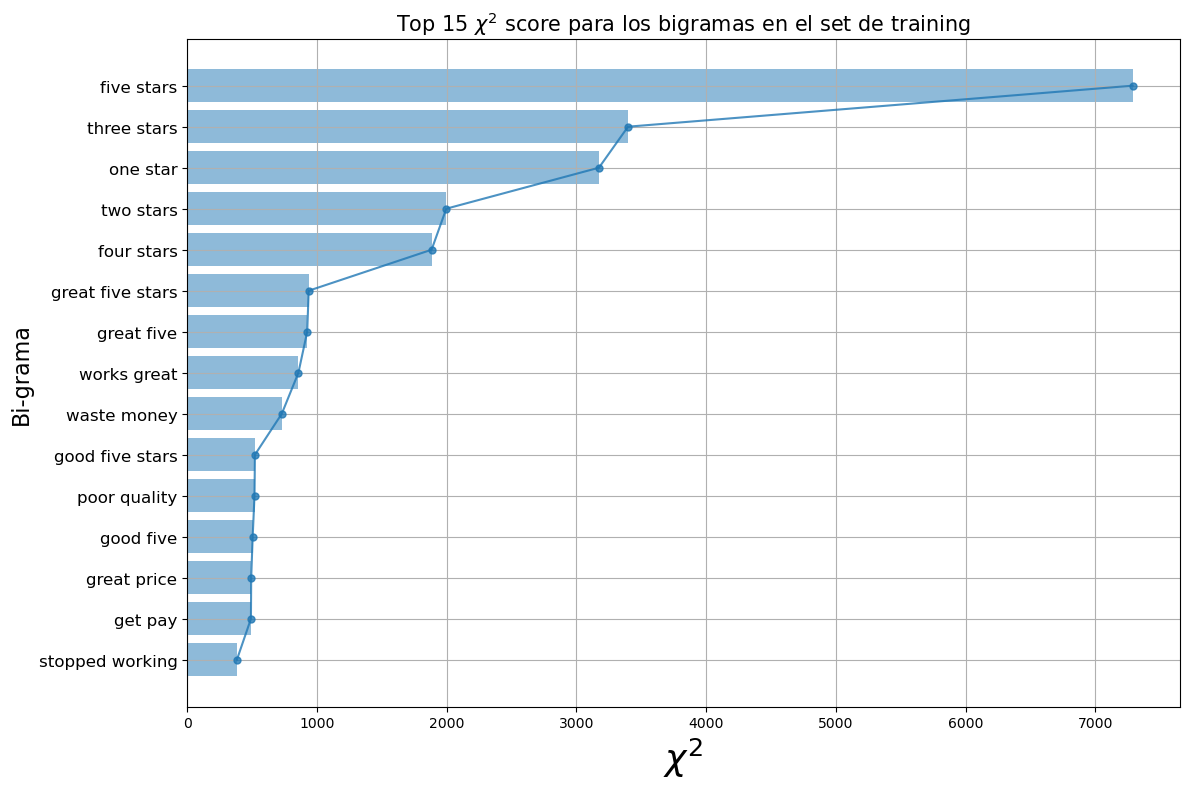

In [73]:
# Compute the chi-squared score for each word in the training set and show the values
i=15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(bow1.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('Bi-grama', fontsize=16)
plt.title('Top {} $\chi^2$ score para los bigramas en el set de training'.format(i), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show();

· Aquí afirmamos lo que intuíamos en el EDA al principio. El corpus tiene mucho más sentimiento positivo en general y los clientes lo refelejan de diversas maneras, como se ve por sus dependencias altas entre los bigramas y sus etiquetas.  
· Los clientes que tienen motivación para emitir una review cualquiera, además de marcar las estrellas en el selector pulsando sobre ellas, también lo escriben con el teclado para reafirmar dicha opinión.  
· Además de usar las estrellas, mayormente los clientes usan los términos "funciona genial" y "altamente recomendable" para opiniones positivas más allá del número de estrellas, o "no funciona", "mala calidad" y "no gastes dinero" para las opiniones negativas.

### *Entrenamiento y evaluación del modelo*

Vamos a usar un modelo de Regresión Logística, que da salida de clasificación y no de valores continuos.

In [58]:
# Vamos a usar una búsqueda de grid iterando sobre el parámetro de regularización "c"
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]
x_ticks = [str(i) for i in c_params ]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=2000)
    lr.fit(X_train_, y_train)

    y_train_predict = lr.predict(X_train_)
    y_test_predict = lr.predict(X_test_)

    print ("Train ccuracy for C={}: {}".format(c, accuracy_score(y_train, y_train_predict)))
    print ("Test ccuracy for C={}: {}\n".format(c, accuracy_score(y_test, y_test_predict)))

    train_acc.append(accuracy_score(y_train, y_train_predict))
    test_acc.append(accuracy_score(y_test, y_test_predict))

Train ccuracy for C=0.01: 0.8004307011227565
Test ccuracy for C=0.01: 0.7950077004620277

Train ccuracy for C=0.05: 0.8359002053497613
Test ccuracy for C=0.05: 0.8269096145768746

Train ccuracy for C=0.25: 0.8485745526308771
Test ccuracy for C=0.25: 0.8363701822109326

Train ccuracy for C=0.5: 0.8514147798490546
Test ccuracy for C=0.5: 0.8369302158129488

Train ccuracy for C=1: 0.852881563858442
Test ccuracy for C=1: 0.8371302278136689

Train ccuracy for C=10: 0.8545950342694082
Test ccuracy for C=10: 0.8363701822109326

Train ccuracy for C=100: 0.8545883670693656
Test ccuracy for C=100: 0.8351701102066124

Train ccuracy for C=1000: 0.8545416966690669
Test ccuracy for C=1000: 0.8351101066063964

Train ccuracy for C=10000: 0.8545816998693229
Test ccuracy for C=10000: 0.8350101006060363



In [59]:
x_ticks

['0.01', '0.05', '0.25', '0.5', '1', '10', '100', '1000', '10000']

Observamos que el mejor accuracy en generalización lo tenemos al no usar regularización (c=1), aunque tampoco es una diferencia excesiva.

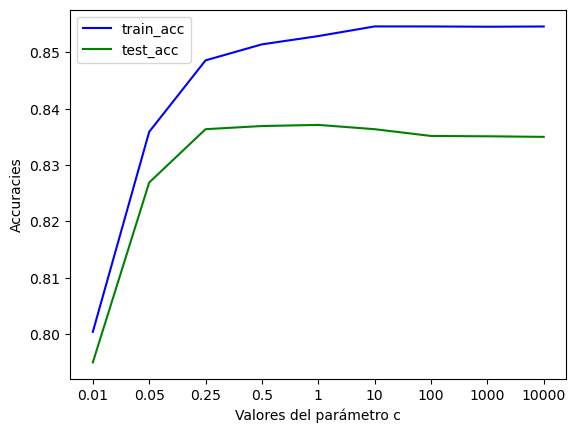

In [60]:
plt.plot(train_acc, c="b")
plt.plot(test_acc, c="g")
plt.legend(["train_acc", "test_acc"])
plt.xticks(ticks=range(0,9,1) ,labels=x_ticks)
plt.xlabel("Valores del parámetro c")
plt.ylabel("Accuracies")
plt.show()

Ahora veremos la matriz de confusión de las predicciones.

In [61]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, y_test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_test_predict)))


Confussion matrix:
[[21699  3314]
 [ 4935 20049]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     25013
           1       0.86      0.80      0.83     24984

    accuracy                           0.84     49997
   macro avg       0.84      0.83      0.83     49997
weighted avg       0.84      0.84      0.83     49997

Accuracy score:0.8350101006060363


Aunque el modelo es mejor con las predicciones del sentimiento positivo, es mejor capturando las negativas en el dataset.

Por último revisaremos la evolución de las métricas de Precission+Recall

In [62]:
p, r, thresholds = precision_recall_curve(y_test, y_test_predict)

In [63]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Funciones de Precision y Recall")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

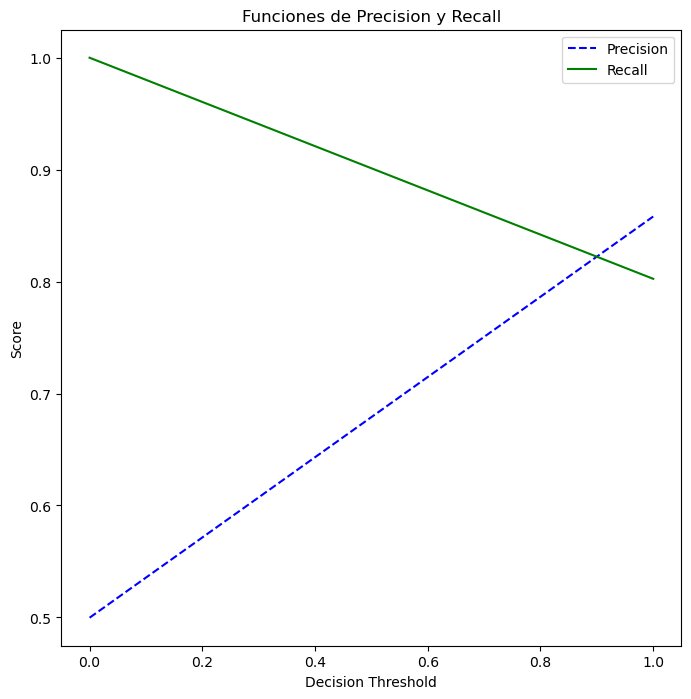

In [64]:
plot_precision_recall_vs_threshold(p, r, thresholds)

Veamos cómo se traduce esto con algunos ejemplos entre etiquetas reales y predichas.

In [65]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(targets.iloc[review_index]['sent']))
    r = features.iloc[review_index]['review']
    print('Prediction: {}'.format(lr.predict(bow1.transform([r]))))

In [66]:
for i in random.sample(range(0, len(features)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 20022
Actual sentiment: 1
Prediction: [1]

Review no. 174613
Actual sentiment: 1
Prediction: [0]

Review no. 89477
Actual sentiment: 0
Prediction: [0]

Review no. 129227
Actual sentiment: 0
Prediction: [0]

Review no. 38699
Actual sentiment: 1
Prediction: [0]


---

<h2 align=center><i>Modelo 2: Modelo de Deep Learning</i></h2>

Usaremos un modelo recursivo LSTM con embeddings obtenidos desde el dataset obtenido usando gensim, sin usar modelo preentrenado.

Importamos las librerías:

In [9]:
import gensim
import multiprocessing as mp

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


Reduciremos el dataset a la mitad para evitar sobrecarga de memoria y procesador.

In [68]:

feats_dl = features[:30000]
targs_dl = targets[:30000]


Agrupamos los parámetros del modelo para modificarlos más fácilmente. Selecciono los adecuados tras varias iteraciones que permitan un tradeoff entre recursos y rendimiento:

In [31]:
# Parámetros del WORD2VEC
W2V_SIZE = 70 # tamaño de vectores
W2V_WINDOW = 7 # número de palabras que va a mirar alrededor
# 32
W2V_EPOCH = 5 # número de epoca
W2V_MIN_COUNT = 2 #número mínimo de frecuencia

# KERAS
SEQUENCE_LENGTH = 50 # número de secuencias de keras

Creamos una función para generar los tokens con Keras:

In [32]:
def generate_tokenizer(train_df):
  #generamos un identificador único para cada una de las palabras
  #creamos el vocabulario (tenemos palabra y número)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Total words: {vocab_size}")
    return tokenizer, vocab_size

Ahora una función para generar los word2vec con gensim:

In [69]:
def generate_word2vec(train_df):
  #para cada review la dividimos en tokens (palabras )
  #para todos los documentos tiene todas las palabras generamos un identificados único para cada una de las palabras
  #generamos el modelo, utilizamos la librería gemsin con los parametros definidos previamente, vocabulario y luego entrenamiento
  
    documents = [_text.split() for _text in train_df.review]
    w2v_model = gensim.models.word2vec.Word2Vec(
        vector_size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    words = w2v_model.wv.key_to_index.keys()
    vocab_size = len(words)
    print(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model

Ahora creamos una función para generar la capa de los embeddings que le sumaremos al modelo.

In [34]:
# Generamos la capa de embeddings
# El modelo no tiene que hacer el fit de la capa de embeddings, se la damos dada

def generate_embedding(word2vec_model, vocab_size, tokenizer):
  # generamos un capa de embedding como en el ejemplo anterior con LSTM y GRU pero
  # en este caso lo hacemos por separado y guardamos el objeto
  # Generamos la matriz de embedding, inicializamos a 0 con el tamaño de  W2V y vocabulario
  # Para cada palabra del vocabulario generamos la representación vectorial de w2v
  # y se la asignamos a la matriz. De este modo, generamos la matrix de equivalencia
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        # Con trainable le indicamos que no se modificar lo que ya viene dentro de esa capa
        trainable=False,
    )

    # Devuelve la capa de embedding

Vamos a hacer el split de los datos

In [35]:
#Cargamos los datos y hacemos split
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(feats_dl.review, targs_dl.sent, train_size=0.75, random_state=42)

Vamos a realizar la ingesta de los datos ya limpios procedentes del paso anterior:

In [36]:
#convertimos a palabras. Una lista con cada review (un string único)

X_train_words = []
for index, example in enumerate(X_train_index):
    X_train_words.append(example)

In [37]:
X_test_words = []
for index, example in enumerate(X_test_index):
    X_test_words.append(example)

Un ejemplo:

In [38]:
X_train_words[10]

'absolute must vo professionals auditions road beginners starting home studio also great pod cast porta booth pro'

In [39]:

X_train_words = pd.DataFrame(X_train_words, columns=["review"])
X_test_words = pd.DataFrame(X_test_words, columns=["review"])

In [40]:
X_train_words.head()

,review
0,wonderful five stars
1,good sent back bc longer needed good
2,looking something band waste money balls spend...
3,things tough tremendous punch put 12at7 bugera...
4,great timing five stars


Ahora vamos a extraer del dataset con la función pre-hecha los tokens:

In [41]:
tokenizer, vocab = generate_tokenizer(X_train_words.review)

Total words: 23707


Vamos la cardinalidad del vocabulario:

In [42]:
word2vec_model = generate_word2vec(X_train_words)

Vocab size: 13399


Vamos a hacer padding con los vectores para que tengan la misma longitud y poder crear los tensores necesarios para TensorFlow:

In [43]:
from tensorflow.keras.utils import pad_sequences


max_words = 50

#Pasamos el pading (500 palabras), tokenizamos pero antes pasamos el texto a secuencias
#Cuando tokenizamos pasamos todas las palabras y se convierte a un identificor único del vocabulario

X_train_words = pad_sequences(tokenizer.texts_to_sequences(X_train_words.review), maxlen=max_words)
X_test_words = pad_sequences(tokenizer.texts_to_sequences(X_test_words.review), maxlen=max_words)

Aplicamos la generación de embeddings con nuestra función:

In [44]:
embedding_layer = generate_embedding(word2vec_model, vocab, tokenizer)

Generamos el modelo y sus capas. Por supuesto, usaremos la capa de salida con activador sigmoide que nos dará la probabilidad de cada etiqueta.

In [45]:
model_custom = Sequential()
#pasamos directamente la capa que hemos generado
model_custom.add(embedding_layer)
#dropout, función entre celdas y el recurrent_dropout añade aleatoriedad (afecta a las gates)
model_custom.add(LSTM(60, dropout=0.3, recurrent_dropout=0.3))
model_custom.add(Dense(1, activation="sigmoid"))

model_custom.summary()

In [47]:
model_custom.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Ahora hacemos otra di¡visión para validation y train para el modelo, y lo entrenamos.  
Guardaré el histórico para graficar el rendimiento:

In [49]:
batch_size = 64
num_epochs = 10

X_train_words_valid, y_valid = X_train_words[:batch_size], y_train_index[:batch_size]  # first batch_size samples
X_train_words2, y_train2 = X_train_words[batch_size:], y_train_index[batch_size:]  # rest for training

H = model_custom.fit(X_train_words2, y_train2,
          validation_data=(X_train_words_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/10
351/351 [==============================] - 707s 2s/step - loss: 0.3960 - accuracy: 0.8189 - val_loss: 0.2599 - val_accuracy: 0.8906
Epoch 2/10
351/351 [==============================] - 683s 2s/step - loss: 0.3426 - accuracy: 0.8486 - val_loss: 0.2378 - val_accuracy: 0.8906
Epoch 3/10
351/351 [==============================] - 664s 2s/step - loss: 0.3230 - accuracy: 0.8559 - val_loss: 0.2422 - val_accuracy: 0.9062
Epoch 4/10
351/351 [==============================] - 681s 2s/step - loss: 0.3114 - accuracy: 0.8582 - val_loss: 0.1940 - val_accuracy: 0.8906
Epoch 5/10
351/351 [==============================] - 646s 2s/step - loss: 0.3059 - accuracy: 0.8625 - val_loss: 0.1905 - val_accuracy: 0.9062
Epoch 6/10
351/351 [==============================] - 645s 2s/step - loss: 0.2974 - accuracy: 0.8672 - val_loss: 0.1785 - val_accuracy: 0.9062
Epoch 7/10
351/351 [==============================] - 647s 2s/step - loss: 0.2925 - accuracy: 0.8696 - val_loss: 0.1919 - val_accuracy: 0.9375

Genero la gráfica de evolución de los errores y el accuracy.

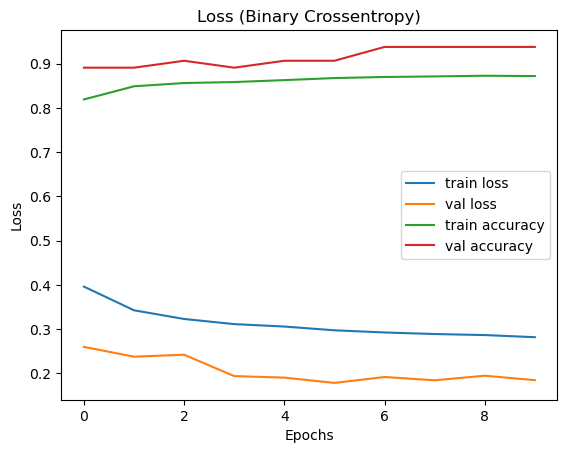

In [52]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['accuracy'], label='train accuracy')
plt.plot(H.history['val_accuracy'], label='val accuracy')
plt.title('Loss (Binary Crossentropy)')
plt.xlabel('Epochs')
#plt.ylim(0,0.3)
plt.ylabel('Loss')
plt.legend()
plt.show()



Realizamos las predicciones sobre el test:

In [60]:
predictions = model_custom.predict(X_test_words)
# Aplico umbral de decisión de 0.5
threshold = 0.5
predictions_class = np.where(predictions >= threshold, 1, 0)

235/235 [==============================] - 19s 79ms/step


In [71]:
predictions[:10]

array([[0.9660059 ],
       [0.9582782 ],
       [0.10192148],
       [0.03678713],
       [0.9697084 ],
       [0.08879656],
       [0.20720133],
       [0.0204176 ],
       [0.04655756],
       [0.6619704 ]], dtype=float32)

In [72]:
predictions_class[:10]

array([[1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1]])

Veamos unas métricas más, esta vez sobre el dataset de Test y las predicciones.

In [66]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test_index, predictions_class)))
print('\nClassification report:\n{}'.format(classification_report(y_test_index, predictions_class)))
print('Accuracy score:{}'.format(accuracy_score(y_test_index, predictions_class)))

Confussion matrix:
[[3314  443]
 [ 492 3251]]

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      3757
           1       0.88      0.87      0.87      3743

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

Accuracy score:0.8753333333333333


· Con un coste computacional muchísimo más alto que ha obligado a reducir el tamaño del dataset y los vectores resultantes del embedding, y con no mucho afinamiento tampoco, hemos conseguido unos primeros mejores resultados en general, de un incremento de aproximadamente un 5% en el accuracy general.  
· Con tan sólo 10 épocas, se han equilibrado los accuracies entre las dos clases, aumentando su puntuación. Además, Se han elevado y equilibrado también los Recalls de ambas categorías y presenta poco overfitting con un DropOut aplicado.  
· En su gráfica de tendencia se ve que el modelo converge hasta cierto punto en que se equilibran, y siguen mejorando las tases de error más allá de las 10 épocas. Con un poco de más ajuste de los hiperparámetros y más épocas, se podrán mejorar los resultados.